In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from covid import World
import numpy as np

In [4]:
def ratio_SIR_numerical(beta, gamma, N, I_0, times):
    """
    Numerical simulation of SIR model with simple Euler stepper in 10*times timesteps, 
    output are two lists contained number of infected and recovered at each timestep
    beta  = transmission coefficient in units of 1/time
    gamma = recovery coefficient in units of 1/time
    N     = overall size of the group
    I_00    = number of initially infected people
    """
    I_list = []
    R_list = []
    I = I_0
    S = N - I_0
    R = 0
    step = 10
    for time in times:
        for i in range(step):
            S = S - beta / step * S * I / N
            I = I + beta / step * S * I / N - gamma / step * I
            R = R + gamma / step * I
        I_list.append(I)
        R_list.append(R)
    return I_list, R_list

# Model parameters 

All parameters of the model are defined in a YAML config file. An example of a config file can be found in ``configs/config_example.yaml``

In [5]:
CONFIG_PATH = "../configs/config_si.yaml"

# Initialize world

To initialize a certain world, we just need to call the ``World.from_config`` constructor:

In [ ]:
world = World.from_config(CONFIG_PATH)

Initializing world...
Reading inputs...


# Running the infection

The general command to start the infection is ``world.group_dynamics()``. The number of days to run, as well as the infection model are configured in the config file.

In [10]:
world.group_dynamics()

Starting group_dynamics for  100  days at day 1
starting the loop ..., at  1  days, to run for  100  days


# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [11]:
data_dict = world.logger.data_dict

In [12]:
# parameters for numerical solution taken data_dict and config file
times = list(data_dict["world"].keys())
N = len(world.boxes.members[0].people)
I_0 = data_dict["world"][1]["infected"]


beta = world.config["infection"]["transmission"]["parameters"]["transmission_probability"]["parameters"]["value"]
beta /= (24 / world.timer.duration_hours) # divide by the number of timesteps we do per day
gamma = world.config["infection"]["symptoms"]["parameters"]["recovery_rate"]
gamma = gamma / (24 / world.timer.duration_hours) * 2
# multiply by 2 to compensate for updating health status twice in each timestep, see interaction/base.py

In [21]:
n_inf, n_rec = ratio_SIR_numerical(beta, gamma, N, I_0, times)

<IPython.core.display.Javascript object>


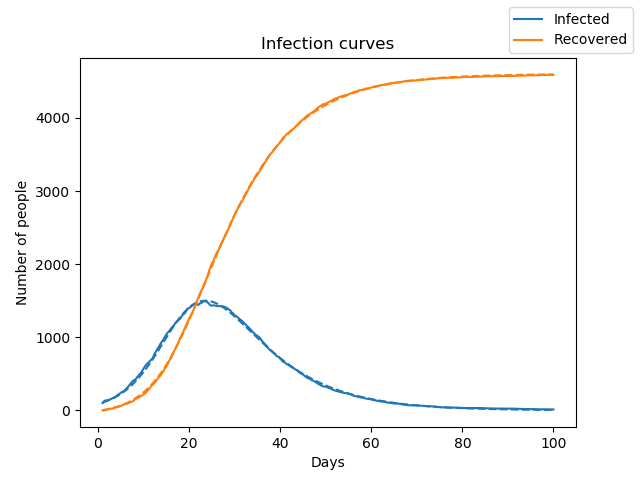

In [31]:
fig, ax = world.logger.plot_infection_curves_per_day()
ax.plot(times, n_inf, color='C0', linestyle='--');
ax.plot(times, n_rec, color='C1', linestyle='--');

Dashed lines are the numerical solution to the differential equation. In this particular case we see very good agreement but due to the stochastic nature of the simulation the results with be different every time and is dependent on the duration of timesteps you do per day. You would expect better agreement the shorter the timesteps. This example is with 3x 8 hour timesteps.